In [104]:
# imports
from scipy import stats
from sirs import Sirs, SirsSolver
from utils import *

In [2]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

400.0


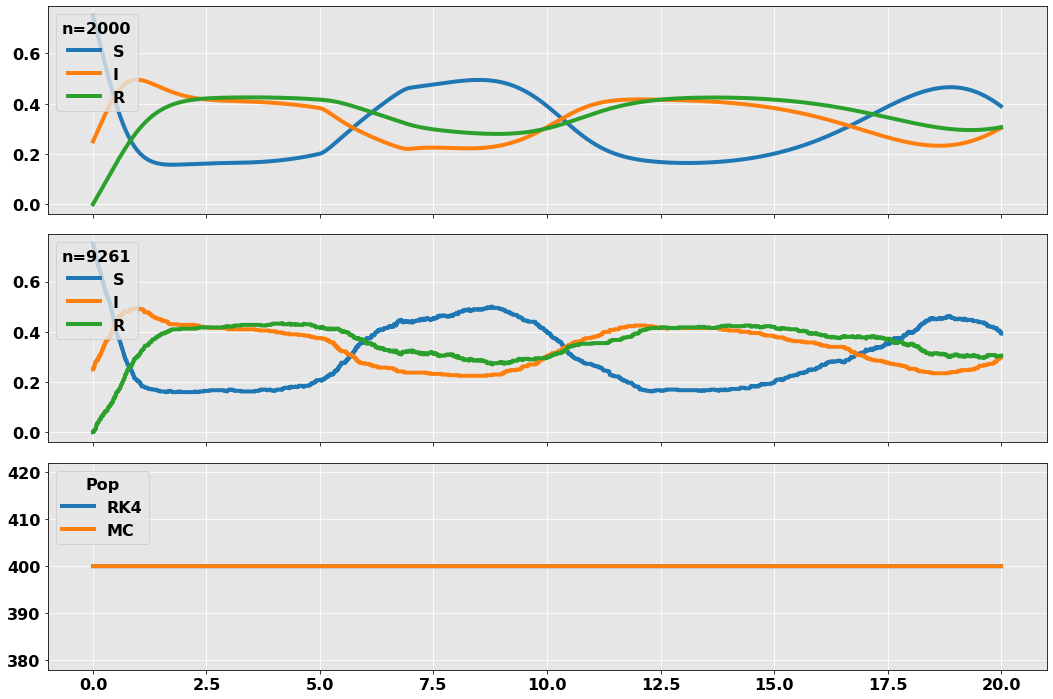

In [121]:
#%%timeit -r 1
t_end = 20

N0 = 400
I0 = 100
A = 0
a = 4
b = 1
c = 1
e = .0
d = .0
dI = .0
F = .0
f = .1

fa = (lambda t: bathtub(t, .1, floor=.6, delay=5, duration=2)*seasonal_variation(t, a=4, A=2, shift=3))

plot_const = False

n = 100*t_end
sirs1 = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f, fa=fa)
solver1 = SirsSolver(sirs1)
solver1.run_rk4(t_end, n)

sirs2 = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f, fa=fa)
solver2 = SirsSolver(sirs2)
solver2.run_mc(t_end, seed=5)


fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(15,10))

ax = axes[0]
S, I, R, _ = solver1.get_fractions()
ax.plot(solver1.t, S)
ax.plot(solver1.t, I)
ax.plot(solver1.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={n}', loc='upper left')
if plot_const:
    s, i, r = sirs1.constant_fractions()
    ax.plot(solver1.t, np.zeros(n+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + r, ':', color=COLORS[2], lw=3)


ax = axes[1]
S, I, R, _ = solver2.get_fractions()
nt = len(solver2.t)
ax.plot(solver2.t, S)
ax.plot(solver2.t, I)
ax.plot(solver2.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={nt}', loc='upper left')
if plot_const:
    s, i, r = sirs2.constant_fractions()
    ax.plot(solver2.t, np.zeros(nt) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + r, ':', color=COLORS[2], lw=3)


ax = axes[2]
ax.plot(solver1.t, solver1.res['N'])
ax.plot(solver2.t, solver2.res['N'])
ax.legend(['RK4', 'MC'], title=f'Pop', loc='upper left')
print(solver2.res['N'].max())

plt.tight_layout()
plt.show()

In [97]:
N0 = 400
I0 = 100
A = 0
a = 4
b = 1
c = 1
e = .0
d = .0
dI = .0
F = .0
f = .1
sirs = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f)
solver = SirsSolver(sirs)
solver.run_mc(t_max=10000)

In [98]:
stats, (S,I,R,N) = solver.get_stats(5)

<BarContainer object of 11 artists>

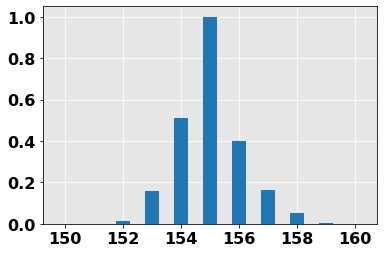

In [101]:
mu, sigma = stats['R']
y, x = np.histogram(R, bins=11, range=(mu-5*sigma, mu+5*sigma))
plt.bar(np.arange(-5,6)+int(mu), y/y.max(), width=.5, align='center')
#plt.xlim(-5.5,5.5)

In [117]:
N0 = 400
I0 = 100
A = 2
a = 4
b = 2
c = 1
e = .012
d = .008
dI = .1
F = .0
f = 0

fa = (lambda t: bathtub(t, .1, floor=.6, delay=5, duration=2)*seasonal_variation(t, a=4, A=2, shift=3))

n = 10
t_max = 50
sirs_list = make_sirs_list(n, N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f, fa=fa)
t, series = mc_stats(sirs_list, seed=0, t_max=t_max)

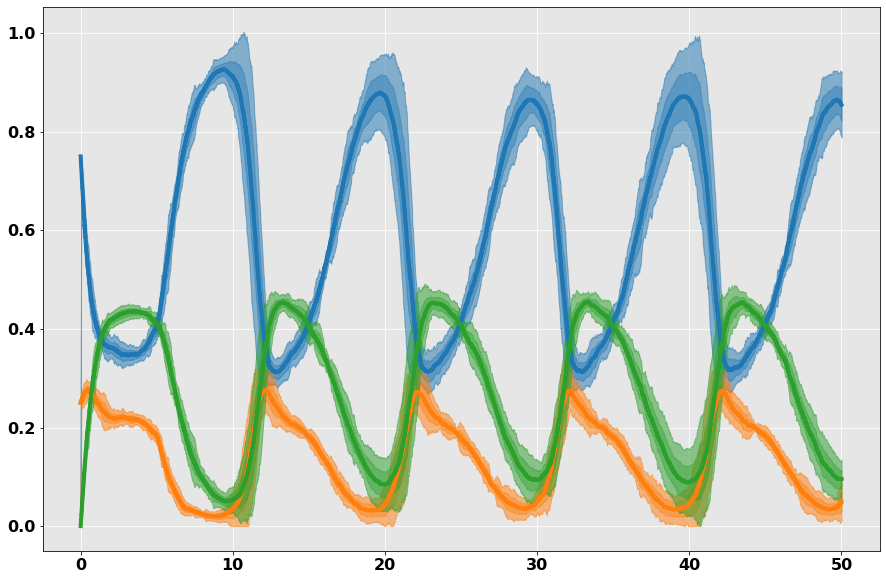

In [118]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(15,10))

ax = axes

filter_length = 100

for i, P in enumerate(['S', 'I', 'R']):
    mu, sigma = series[P]
    ax.plot(t, mu, color=COLORS[i])

    mu = np.convolve(mu, np.ones(filter_length))[:-1*(filter_length-1)]/filter_length
    sigma = np.convolve(sigma, np.ones(filter_length))[:-1*(filter_length-1)]/filter_length
    t_alpha = scipy.stats.t.ppf(.90, n-1)
    upper = mu + t_alpha*sigma
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    ax.fill_between(t, lower, upper, color=COLORS[i], alpha=.4)
    t_alpha = scipy.stats.t.ppf(.99, n-1)
    upper = mu + t_alpha*sigma
    lower = mu - t_alpha*sigma
    lower[lower < 0] = 0
    ax.fill_between(t, lower, upper, color=COLORS[i], alpha=.5)

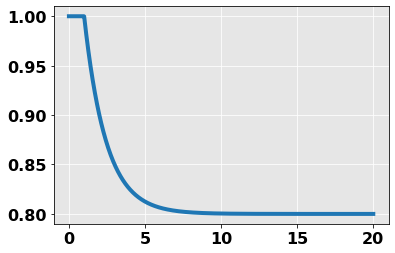

In [95]:
plt.plot(x:=np.linspace(0,20,1000), [exponential_decay(xi, 1, floor=.8, delay=1) for xi in x])

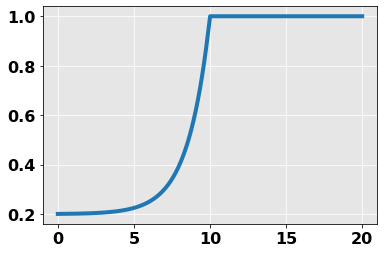

In [97]:
plt.plot(x:=np.linspace(0,20,1000), [exponential_growth(xi, 1, floor=.2, delay=10) for xi in x])

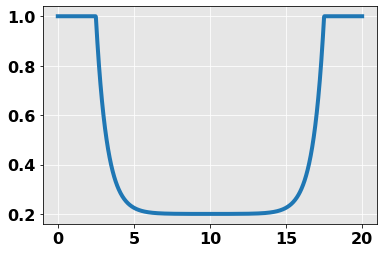

In [102]:
plt.plot(x:=np.linspace(0,20,1000), [bathtub(xi, .5, floor=.2, delay=2.5, duration=15) for xi in x])

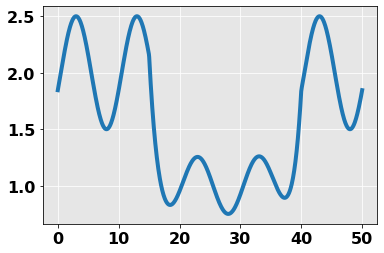

In [108]:
fa = (lambda t: bathtub(t, 1, floor=.5, delay=15, duration=25)*seasonal_variation(t, a=2, shift=3))
plt.plot(x:=np.linspace(0,50,1000), [fa(xi) for xi in x])